## **Import statments**


In [267]:
!pip install tensorflow umap-learn hdbscan
import pandas as pd
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score, precision_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    roc_curve, auc,roc_auc_score
)

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from imblearn.over_sampling import SMOTE

import umap.umap_ as umap

# **EDA**

In [268]:
# Load the Data
DED_data = pd.read_csv('/content/Dry_Eye_Dataset.csv')

Dry Eye Disease
Y    13037
N     6963
Name: count, dtype: int64


<ipython-input-269-7827fedb8571>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=DED_data, x='Dry Eye Disease', palette='pastel')


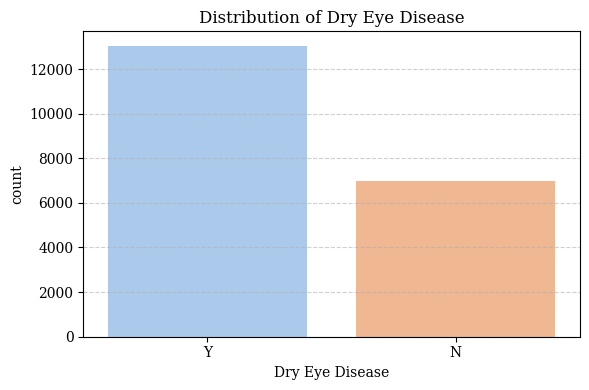

In [269]:
# Count the occurrences of each class in the target variable
class_counts = DED_data['Dry Eye Disease'].value_counts()

# Print the class distribution
print(class_counts)

#class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=DED_data, x='Dry Eye Disease', palette='pastel')
plt.title('Distribution of Dry Eye Disease')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [270]:
# Display the first few rows of the dataset to understand its structure
pd.set_option('display.max_columns', None)
DED_data.head()

,Gender,Age,Sleep duration,Sleep quality,Stress level,Blood pressure,Heart rate,Daily steps,Physical activity,Height,Weight,Sleep disorder,Wake up during night,Feel sleepy during day,Caffeine consumption,Alcohol consumption,Smoking,Medical issue,Ongoing medication,Smart device before bed,Average screen time,Blue-light filter,Discomfort Eye-strain,Redness in eye,Itchiness/Irritation in eye,Dry Eye Disease
0,F,24,9.5,2,1,137/89,67,3000,31,161,69,Y,N,N,N,N,N,Y,Y,N,8.7,N,Y,Y,N,Y
1,M,39,9.6,2,3,108/64,60,12000,74,164,87,N,N,N,N,Y,N,Y,Y,N,9.6,Y,N,N,Y,Y
2,F,45,5.4,1,5,134/81,95,12000,93,179,94,Y,Y,N,Y,Y,N,N,N,Y,4.0,N,Y,N,N,N
3,F,45,5.4,4,5,110/90,78,19000,32,160,77,N,N,N,Y,N,N,Y,N,N,7.6,N,Y,N,Y,N
4,F,42,5.7,3,2,99/67,72,4000,173,179,99,N,Y,N,N,N,N,Y,N,N,3.5,N,Y,Y,N,Y


In [271]:
# Show the shape (number of rows and columns)
DED_data.shape

(20000, 26)

In [272]:
# Show the number of examples in each class
print(DED_data['Dry Eye Disease'].value_counts())

Dry Eye Disease
Y    13037
N     6963
Name: count, dtype: int64


In [273]:
# Check data types and null values
DED_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Gender                       20000 non-null  object 
 1   Age                          20000 non-null  int64  
 2   Sleep duration               20000 non-null  float64
 3   Sleep quality                20000 non-null  int64  
 4   Stress level                 20000 non-null  int64  
 5   Blood pressure               20000 non-null  object 
 6   Heart rate                   20000 non-null  int64  
 7   Daily steps                  20000 non-null  int64  
 8   Physical activity            20000 non-null  int64  
 9   Height                       20000 non-null  int64  
 10  Weight                       20000 non-null  int64  
 11  Sleep disorder               20000 non-null  object 
 12  Wake up during night         20000 non-null  object 
 13  Feel sleepy duri

In [274]:
# Summary statistics of numerical columns
summary_statistics = DED_data.describe()
summary_statistics

,Age,Sleep duration,Sleep quality,Stress level,Heart rate,Daily steps,Physical activity,Height,Weight,Average screen time
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,31.422800,6.998245,2.997250,2.993750,79.912200,10536.900000,90.069750,174.865900,74.891850,5.519885
std,8.103717,1.731723,1.412283,1.407235,11.808279,5752.729186,52.317283,14.719903,14.733839,2.606305
min,18.000000,4.000000,1.000000,1.000000,60.000000,1000.000000,0.000000,150.000000,50.000000,1.000000
25%,24.000000,5.500000,2.000000,2.000000,70.000000,6000.000000,45.000000,162.000000,62.000000,3.300000
50%,31.000000,7.000000,3.000000,3.000000,80.000000,11000.000000,91.000000,175.000000,75.000000,5.500000
75%,39.000000,8.500000,4.000000,4.000000,90.000000,16000.000000,135.000000,188.000000,88.000000,7.800000
max,45.000000,10.000000,5.000000,5.000000,100.000000,20000.000000,180.000000,200.000000,100.000000,10.000000


In [275]:
# Data types of each column
DED_data.dtypes

,0
Gender,object
Age,int64
Sleep duration,float64
Sleep quality,int64
Stress level,int64
Blood pressure,object
Heart rate,int64
Daily steps,int64
Physical activity,int64
Height,int64


In [276]:
# Check for Missing values / Null values in the dataset

missing_values = DED_data.isnull().sum()
missing_values

,0
Gender,0
Age,0
Sleep duration,0
Sleep quality,0
Stress level,0
Blood pressure,0
Heart rate,0
Daily steps,0
Physical activity,0
Height,0


In [277]:
# Check for duplicate rows in the dataset
duplicate_rows = DED_data.duplicated()
num_duplicates = duplicate_rows.sum()
num_duplicates

np.int64(0)

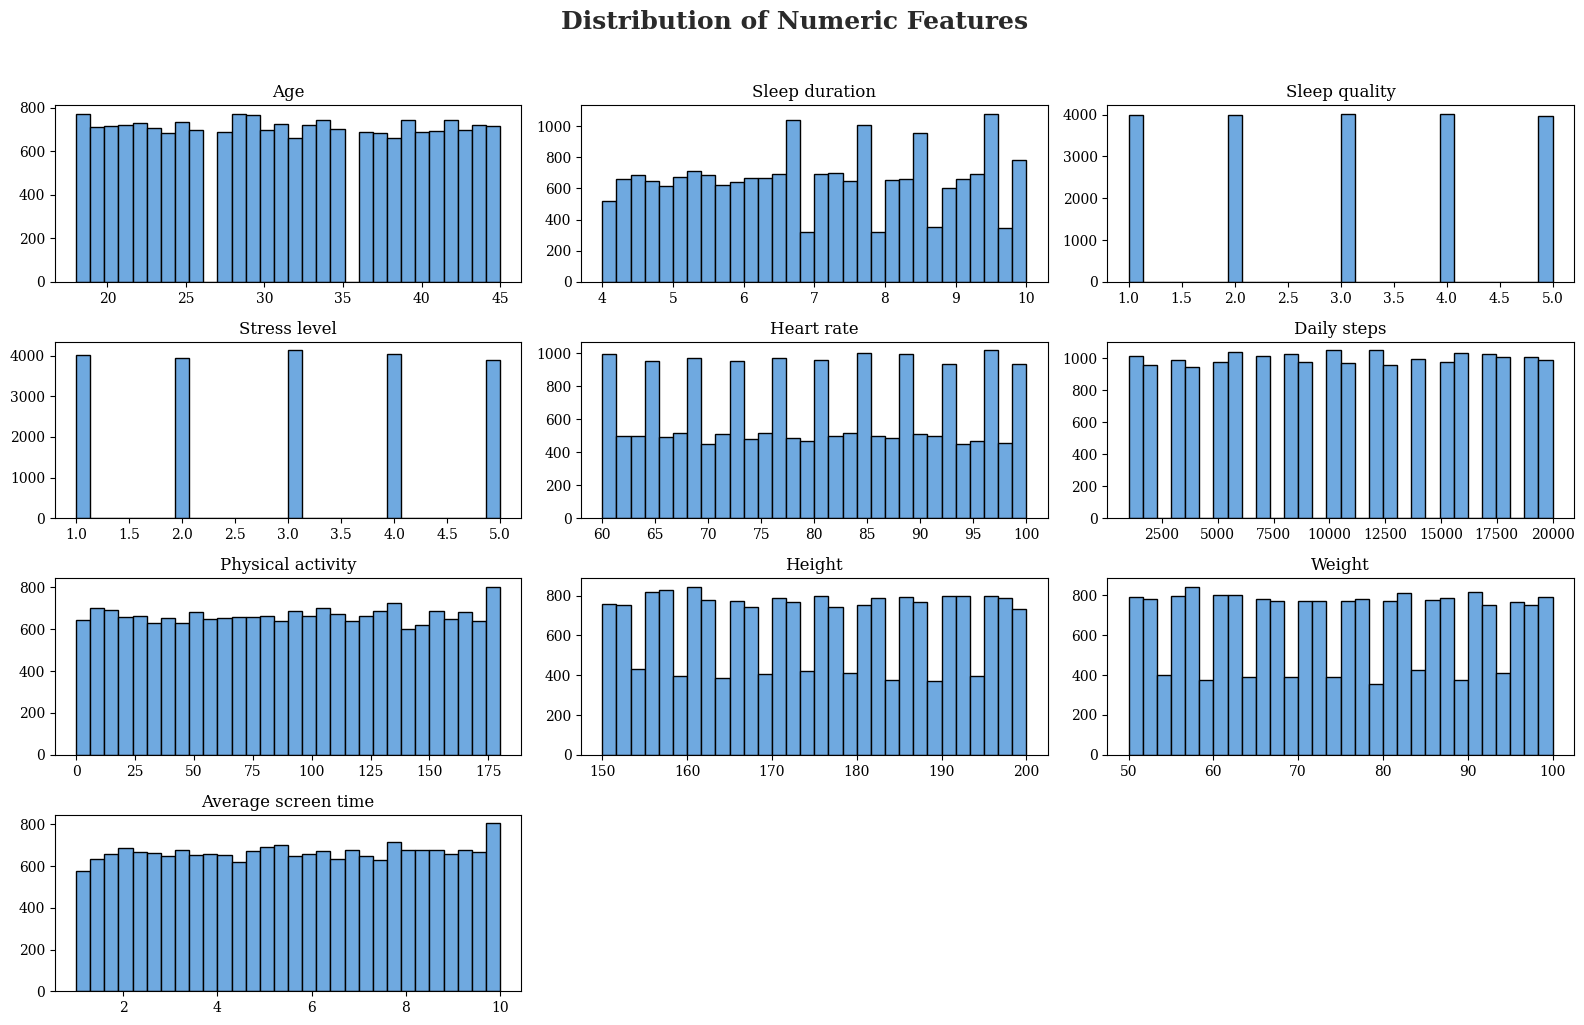

In [278]:
# Exploring Feature Relationships and Distribution:

# Set custom font properties globally
plt.rcParams['font.family'] = 'serif'

# Plot histograms
DED_data.hist(figsize=(16, 10), bins=30, color='#6FA9E0', edgecolor='black',grid=False)

# Add a main title
plt.suptitle('Distribution of Numeric Features', fontsize=18, color='#2a2a2a', fontweight='bold', y=1.02)

# Display the plot
plt.tight_layout()
plt.show()


In [279]:
# IQR Method for Outlier Detection

# Select numerical features
numeric_cols = DED_data.select_dtypes(include=['int64', 'float64']).columns

# IQR Method
outliers_iqr = {}
for col in numeric_cols:
    Q1 = DED_data[col].quantile(0.25)
    Q3 = DED_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = DED_data[(DED_data[col] < lower) | (DED_data[col] > upper)]
    outliers_iqr[col] = outliers.shape[0]

# Print the results
print("\nIQR Outliers (count per feature):")
print(pd.Series(outliers_iqr))



IQR Outliers (count per feature):
Age                    0
Sleep duration         0
Sleep quality          0
Stress level           0
Heart rate             0
Daily steps            0
Physical activity      0
Height                 0
Weight                 0
Average screen time    0
dtype: int64


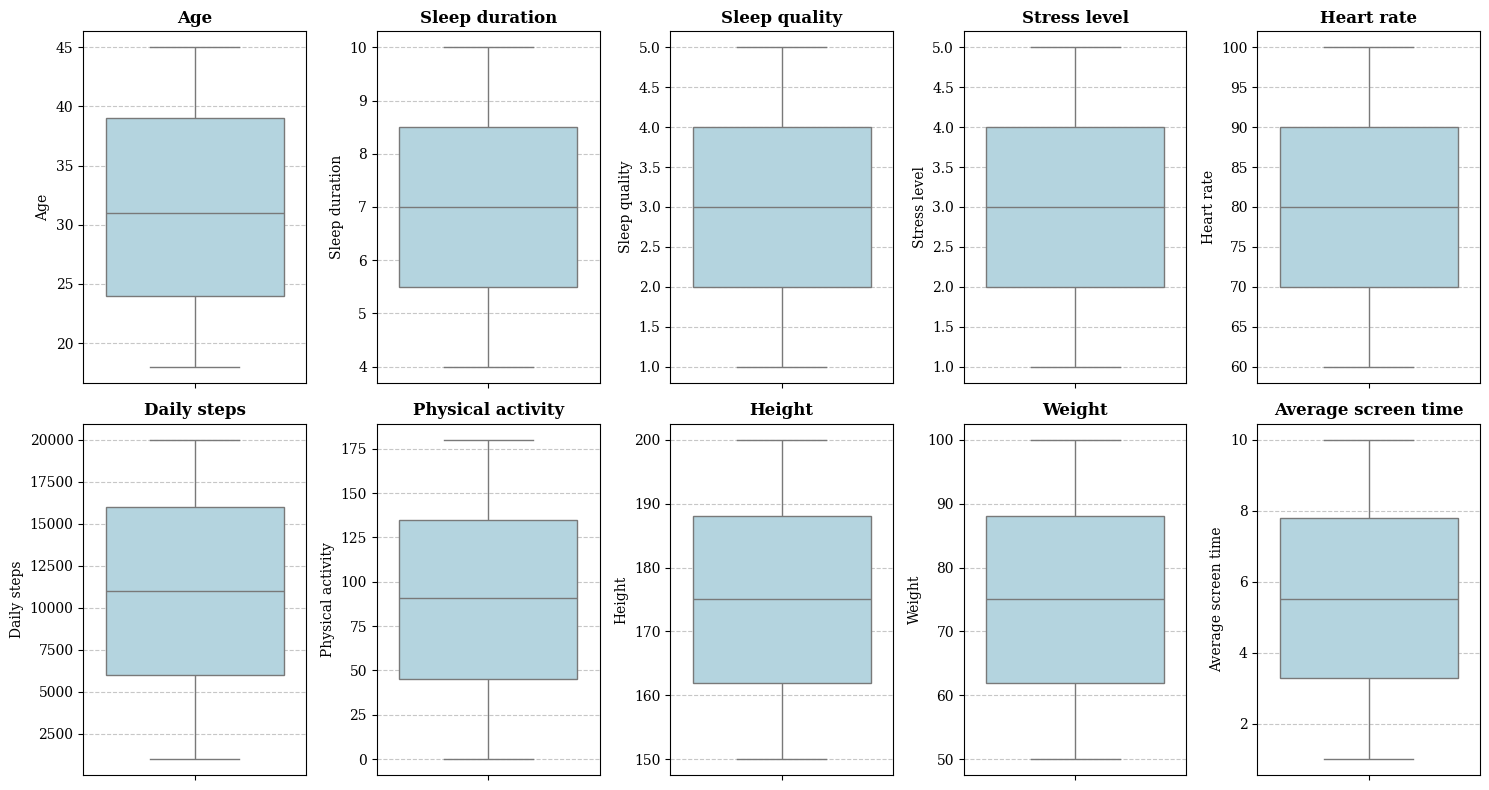

In [280]:
# Boxplots to visualize potential outliers in numerical features

# Select numerical features
numeric_cols = ['Age', 'Sleep duration', 'Sleep quality', 'Stress level', 'Heart rate',
                'Daily steps', 'Physical activity', 'Height', 'Weight', 'Average screen time']

# Set up the figure layout
num_features = len(numeric_cols)
fig, axes = plt.subplots(nrows=2, ncols=(num_features // 2) + (num_features % 2), figsize=(15, 8))
axes = axes.flatten()

# Create IQR boxplots for each numerical feature
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=DED_data[col], ax=axes[i], color="lightblue")
    axes[i].set_title(col, fontsize=12, fontweight='bold')
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

# **Preprocessing**

## **Data Cleaning**

In [281]:
'''
After reviewing the dataset, the following aspects were checked to ensure data quality:

Since There is :
    - NO missing/null values
    - NO duplicate rows
    - Format is standerd in all categorical columns (NO whitespaces, Standardize to Title Case)

Conclusion:
    - the dataset is already clean and well-structured, no additional data cleaning steps were required.
    - The focus was directed towards feature transformation and preparation for modeling.
'''
# Standardize formatting of categorical columns (strip whitespaces, unify casing if needed)
categorical_cols = DED_data.select_dtypes(include='object').columns

for col in categorical_cols:
    DED_data[col] = DED_data[col].str.strip()  # Remove leading/trailing spaces
    DED_data[col] = DED_data[col].str.title()  # Standardize to Title Case ('yes' -> 'Yes')


# Final check
print("\nData cleaned successfully. Dataset shape:", DED_data.shape)


Data cleaned successfully. Dataset shape: (20000, 26)


## **Feature Engineering 🪓**

In [282]:
# Split Blood pressure into two numerical columns
DED_data[['Systolic_BP', 'Diastolic_BP']] = DED_data['Blood pressure'].str.split('/', expand=True).astype(int)

#Drop the original 'Blood pressure' column
DED_data.drop('Blood pressure', axis=1, inplace=True)

In [283]:
pd.set_option('display.max_columns', None)
DED_data.head() # Confirm new columns added

,Gender,Age,Sleep duration,Sleep quality,Stress level,Heart rate,Daily steps,Physical activity,Height,Weight,Sleep disorder,Wake up during night,Feel sleepy during day,Caffeine consumption,Alcohol consumption,Smoking,Medical issue,Ongoing medication,Smart device before bed,Average screen time,Blue-light filter,Discomfort Eye-strain,Redness in eye,Itchiness/Irritation in eye,Dry Eye Disease,Systolic_BP,Diastolic_BP
0,F,24,9.5,2,1,67,3000,31,161,69,Y,N,N,N,N,N,Y,Y,N,8.7,N,Y,Y,N,Y,137,89
1,M,39,9.6,2,3,60,12000,74,164,87,N,N,N,N,Y,N,Y,Y,N,9.6,Y,N,N,Y,Y,108,64
2,F,45,5.4,1,5,95,12000,93,179,94,Y,Y,N,Y,Y,N,N,N,Y,4.0,N,Y,N,N,N,134,81
3,F,45,5.4,4,5,78,19000,32,160,77,N,N,N,Y,N,N,Y,N,N,7.6,N,Y,N,Y,N,110,90
4,F,42,5.7,3,2,72,4000,173,179,99,N,Y,N,N,N,N,Y,N,N,3.5,N,Y,Y,N,Y,99,67


In [284]:
# Move 'Dry Eye Disease' to the end of the dataframe
target_col = 'Dry Eye Disease'
columns = [col for col in DED_data.columns if col != target_col] + [target_col]
DED_data = DED_data[columns]

In [285]:
pd.set_option('display.max_columns', None)
DED_data.head() # Confirm new column order

,Gender,Age,Sleep duration,Sleep quality,Stress level,Heart rate,Daily steps,Physical activity,Height,Weight,Sleep disorder,Wake up during night,Feel sleepy during day,Caffeine consumption,Alcohol consumption,Smoking,Medical issue,Ongoing medication,Smart device before bed,Average screen time,Blue-light filter,Discomfort Eye-strain,Redness in eye,Itchiness/Irritation in eye,Systolic_BP,Diastolic_BP,Dry Eye Disease
0,F,24,9.5,2,1,67,3000,31,161,69,Y,N,N,N,N,N,Y,Y,N,8.7,N,Y,Y,N,137,89,Y
1,M,39,9.6,2,3,60,12000,74,164,87,N,N,N,N,Y,N,Y,Y,N,9.6,Y,N,N,Y,108,64,Y
2,F,45,5.4,1,5,95,12000,93,179,94,Y,Y,N,Y,Y,N,N,N,Y,4.0,N,Y,N,N,134,81,N
3,F,45,5.4,4,5,78,19000,32,160,77,N,N,N,Y,N,N,Y,N,N,7.6,N,Y,N,Y,110,90,N
4,F,42,5.7,3,2,72,4000,173,179,99,N,Y,N,N,N,N,Y,N,N,3.5,N,Y,Y,N,99,67,Y


## **Label Encoding 📝**

In [286]:
# Identify non-numeric columns
non_numeric_cols = DED_data.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)

# Convert categorical columns to numerical using Label Encoding
for col in non_numeric_cols:
    DED_data[col] = DED_data[col].astype('category').cat.codes

Non-numeric columns: Index(['Gender', 'Sleep disorder', 'Wake up during night',
       'Feel sleepy during day', 'Caffeine consumption', 'Alcohol consumption',
       'Smoking', 'Medical issue', 'Ongoing medication',
       'Smart device before bed', 'Blue-light filter', 'Discomfort Eye-strain',
       'Redness in eye', 'Itchiness/Irritation in eye', 'Dry Eye Disease'],
      dtype='object')


In [287]:
#  Check Encoding Results
pd.set_option('display.max_columns', None)
DED_data.head()

,Gender,Age,Sleep duration,Sleep quality,Stress level,Heart rate,Daily steps,Physical activity,Height,Weight,Sleep disorder,Wake up during night,Feel sleepy during day,Caffeine consumption,Alcohol consumption,Smoking,Medical issue,Ongoing medication,Smart device before bed,Average screen time,Blue-light filter,Discomfort Eye-strain,Redness in eye,Itchiness/Irritation in eye,Systolic_BP,Diastolic_BP,Dry Eye Disease
0,0,24,9.5,2,1,67,3000,31,161,69,1,0,0,0,0,0,1,1,0,8.7,0,1,1,0,137,89,1
1,1,39,9.6,2,3,60,12000,74,164,87,0,0,0,0,1,0,1,1,0,9.6,1,0,0,1,108,64,1
2,0,45,5.4,1,5,95,12000,93,179,94,1,1,0,1,1,0,0,0,1,4.0,0,1,0,0,134,81,0
3,0,45,5.4,4,5,78,19000,32,160,77,0,0,0,1,0,0,1,0,0,7.6,0,1,0,1,110,90,0
4,0,42,5.7,3,2,72,4000,173,179,99,0,1,0,0,0,0,1,0,0,3.5,0,1,1,0,99,67,1


## **Feature Scaling (Normalization)**

In [288]:
# MinMax

# Define the Numerical Features to Scale
numeric_features = [
    'Age', 'Sleep duration', 'Sleep quality', 'Stress level',
    'Heart rate', 'Daily steps', 'Physical activity',
    'Height', 'Weight', 'Average screen time',
    'Systolic_BP', 'Diastolic_BP']

# Apply Min-Max Scaling
scaler = MinMaxScaler()
DED_data[numeric_features] = pd.DataFrame(
    scaler.fit_transform(DED_data[numeric_features]),
    columns=numeric_features,
    index=DED_data.index)

# Display the first 5 rows after normalization
DED_data.head()


,Gender,Age,Sleep duration,Sleep quality,Stress level,Heart rate,Daily steps,Physical activity,Height,Weight,Sleep disorder,Wake up during night,Feel sleepy during day,Caffeine consumption,Alcohol consumption,Smoking,Medical issue,Ongoing medication,Smart device before bed,Average screen time,Blue-light filter,Discomfort Eye-strain,Redness in eye,Itchiness/Irritation in eye,Systolic_BP,Diastolic_BP,Dry Eye Disease
0,0,0.222222,0.916667,0.25,0.00,0.175,0.105263,0.172222,0.22,0.38,1,0,0,0,0,0,1,1,0,0.855556,0,1,1,0,0.94,0.966667,1
1,1,0.777778,0.933333,0.25,0.50,0.000,0.578947,0.411111,0.28,0.74,0,0,0,0,1,0,1,1,0,0.955556,1,0,0,1,0.36,0.133333,1
2,0,1.000000,0.233333,0.00,1.00,0.875,0.578947,0.516667,0.58,0.88,1,1,0,1,1,0,0,0,1,0.333333,0,1,0,0,0.88,0.700000,0
3,0,1.000000,0.233333,0.75,1.00,0.450,0.947368,0.177778,0.20,0.54,0,0,0,1,0,0,1,0,0,0.733333,0,1,0,1,0.40,1.000000,0
4,0,0.888889,0.283333,0.50,0.25,0.300,0.157895,0.961111,0.58,0.98,0,1,0,0,0,0,1,0,0,0.277778,0,1,1,0,0.18,0.233333,1


## **Features Relationship**

In [289]:
# 1. Compute Correlation Matrix with the target

target_corr_matrix = DED_data.corr().abs()
print(target_corr_matrix["Dry Eye Disease"].sort_values(ascending=False))

Dry Eye Disease                1.000000
Discomfort Eye-strain          0.109866
Redness in eye                 0.103410
Itchiness/Irritation in eye    0.101300
Average screen time            0.022490
Gender                         0.016321
Smart device before bed        0.013320
Alcohol consumption            0.011258
Systolic_BP                    0.007289
Height                         0.006437
Daily steps                    0.005664
Stress level                   0.005481
Age                            0.005258
Smoking                        0.005126
Diastolic_BP                   0.005051
Blue-light filter              0.005023
Sleep quality                  0.004990
Feel sleepy during day         0.004730
Ongoing medication             0.004188
Physical activity              0.003289
Caffeine consumption           0.002831
Sleep disorder                 0.002619
Weight                         0.002450
Heart rate                     0.002083
Medical issue                  0.001080


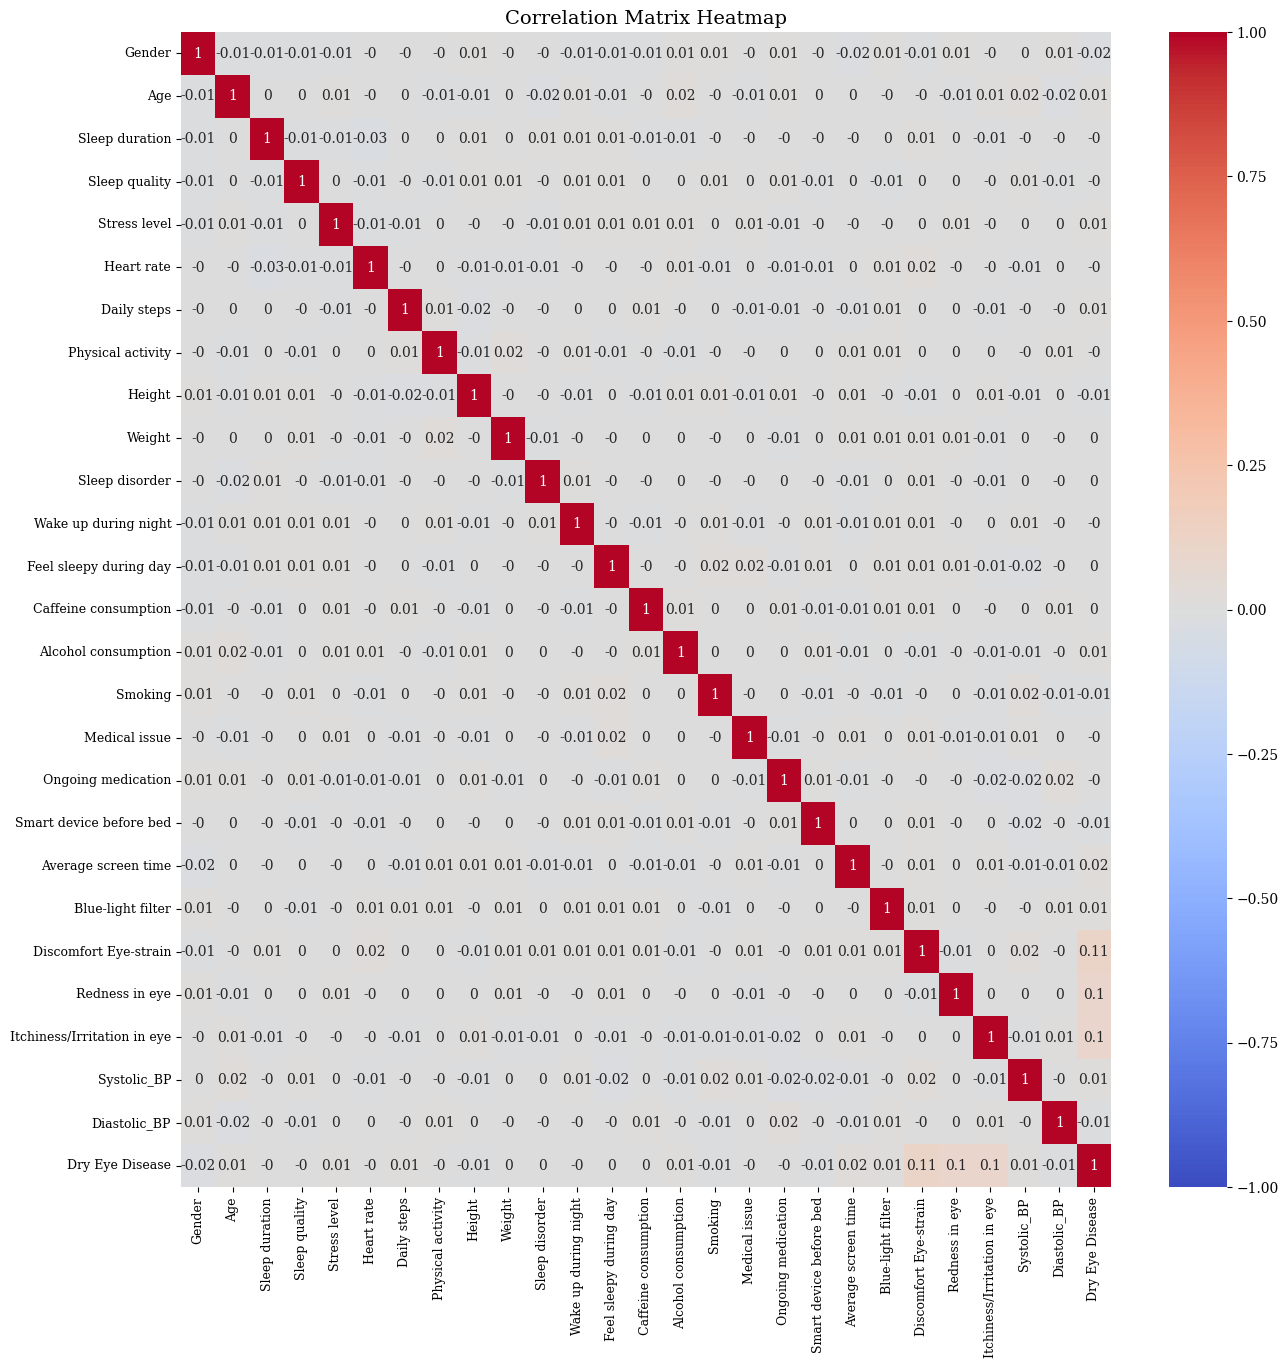

In [290]:
# 2. Plot Correlation Matrix

corr_matrix = DED_data.corr().round(2)
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap', fontsize=14)
plt.xticks(fontsize=9, rotation=90)
plt.yticks(fontsize=9)
plt.show()

# ***Unsupervised Model Implementation***

# **Sampling**

In [291]:
#  Sample the dataset (stratified)

sample_df, _ = train_test_split(
    DED_data,
    stratify=DED_data['Dry Eye Disease'],              #ensures that the balance of 'Yes' & 'No'
    train_size=8000,
    random_state=42                                   #sampling is  same every time you run
)
sample_x = sample_df.drop(columns=['Dry Eye Disease'])

# **Auto Encoder**

## **implement Auto Encoder**

In [292]:

# setting a random seed to make sure ML results are reproducible ;  get  same results every time you run the notebook
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [293]:
input_dim = sample_x .shape[1]  # Number of input features
encoding_dim = 5                     # Bottleneck size — compressed representation

# 2. Build/Define Autoencoder architecture

# Input layer — expects 11 input features
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(16, activation='relu')(input_layer)   # First encoder layer
encoded = Dropout(0.2)(encoded)                       # Dropout to reduce overfitting
encoded = Dense(12, activation='relu')(encoded)       # Second encoder layer

# Latent Layer — compressed representation
latent = Dense(encoding_dim, activation='relu', name='latent_space')(encoded)

# Decoder — reconstructs from compressed data
decoded = Dense(12, activation='relu')(latent)
decoded = Dense(16, activation='relu')(decoded)

# Output layer — must match input shape
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

# 4. Create the Autoencoder & Encoder Models
autoencoder = Model(inputs=input_layer, outputs=output_layer)  # full autoencoder: encode → decode
encoder = Model(inputs=input_layer, outputs=latent)            # encoder only: input → latent

# Compile model
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


In [294]:
# Early Stopping                                                                - Automatically stop training when validation loss doesn’t improve
early_stop = EarlyStopping(
    monitor='val_loss',        # Watch validation loss
    patience=10,               # Stop after 10 epochs of no improvement
    restore_best_weights=True # Restore the best weights
)


# 5. Train the autoencoder
history = autoencoder.fit(
    sample_x,sample_x,
    epochs=300,                          # model will go through the full dataset 300 times during training.
    batch_size=35,                       # data is split into small chunks of 35 samples during each training step.
    validation_split=0.2,
    shuffle=True,
    verbose=1,                           #Shows a progress bar with details of each epoch while training.
    callbacks=[early_stop]               #stops training if validation loss stops improving
)



Epoch 1/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.1762 - val_loss: 0.1633
Epoch 2/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1621 - val_loss: 0.1489
Epoch 3/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1514 - val_loss: 0.1422
Epoch 4/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1457 - val_loss: 0.1383
Epoch 5/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1420 - val_loss: 0.1353
Epoch 6/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1394 - val_loss: 0.1334
Epoch 7/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1380 - val_loss: 0.1326
Epoch 8/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1369 - val_loss: 0.1316
Epoch 9/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1362 - val_loss: 0.1311
Epoch 10/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1353 - val_loss: 0.1304
Epoch 11/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1347 - val_loss: 0.1303
Epoch 12/300
183/183 ━━━━━━━━━━━━━━━━━━━

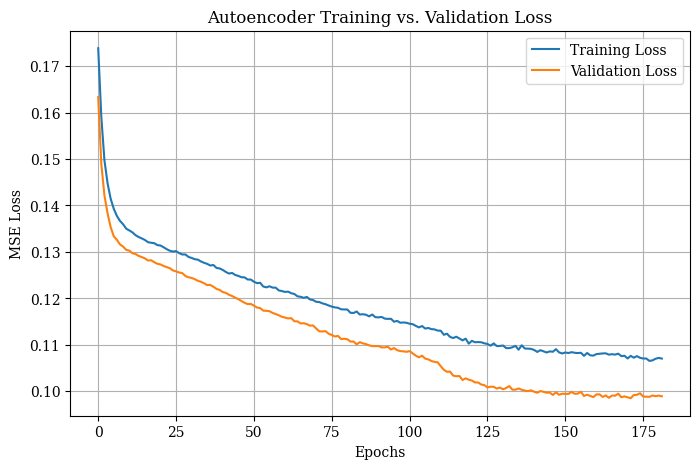

In [295]:
# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Autoencoder Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## **Reconstruction Error per Sample**

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Reconstruction Error Stats:
Mean: 0.0981058070987125
Median: 0.09814018477968166
Max: 0.1651671181223777
Min: 0.03002173490392464


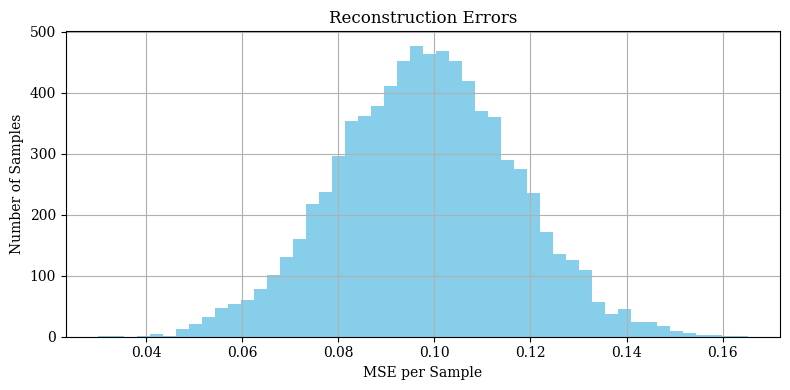

In [296]:
# Predict reconstruction
X_reconstructed = autoencoder.predict(sample_x)

# Compute reconstruction error per sample
reconstruction_errors = np.mean((sample_x  - X_reconstructed) ** 2, axis=1)

# Display Error Statistics
print("Reconstruction Error Stats:")
print("Mean:", np.mean(reconstruction_errors))
print("Median:", np.median(reconstruction_errors))
print("Max:", np.max(reconstruction_errors))
print("Min:", np.min(reconstruction_errors))

#Plot Reconstruction Error Distribution
plt.figure(figsize=(8, 4))
plt.hist(reconstruction_errors, bins=50, color='skyblue')
plt.title("Reconstruction Errors")
plt.xlabel("MSE per Sample")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.tight_layout()
plt.show()

## **Compare input and output side by side**

In [297]:
samples_to_compare = [0, 1, 2]

comparison_dict = {}

for i in samples_to_compare:
    comparison_dict[f"Original_{i}"] = sample_x.iloc[i]
    comparison_dict[f"Reconstructed_{i}"] = X_reconstructed[i]

comparison_df = pd.DataFrame(comparison_dict).T
display(comparison_df)


,Gender,Age,Sleep duration,Sleep quality,Stress level,Heart rate,Daily steps,Physical activity,Height,Weight,Sleep disorder,Wake up during night,Feel sleepy during day,Caffeine consumption,Alcohol consumption,Smoking,Medical issue,Ongoing medication,Smart device before bed,Average screen time,Blue-light filter,Discomfort Eye-strain,Redness in eye,Itchiness/Irritation in eye,Systolic_BP,Diastolic_BP
Original_0,1.000000,0.925926,0.550000,0.750000,0.750000,0.550000,0.842105,0.450000,0.420000,0.840000,0.000000,1.000000,1.000000,0.000000e+00,0.000000,1.000000,0.000000e+00,1.000000,0.000000,0.122222,0.000000,1.000000,1.000000,1.000000,0.880000,0.733333
Reconstructed_0,0.999844,0.504209,0.534242,0.478528,0.517644,0.536976,0.550791,0.553974,0.499603,0.546841,0.034920,0.471538,0.678557,2.133130e-17,0.314283,0.377934,3.253037e-14,0.949844,0.644222,0.511863,0.279080,0.970952,0.965550,0.710988,0.529825,0.509136
Original_1,0.000000,0.777778,0.250000,0.750000,0.750000,0.725000,0.052632,0.550000,0.520000,0.280000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,1.000000,1.000000e+00,0.000000,1.000000,0.122222,1.000000,0.000000,0.000000,1.000000,0.980000,0.733333
Reconstructed_1,0.029031,0.543263,0.558561,0.527198,0.567267,0.514528,0.580000,0.556855,0.535218,0.573935,0.118986,0.315193,0.828039,1.858573e-03,0.335835,0.979099,1.000000e+00,0.036072,0.595292,0.500769,0.437805,0.001976,0.000000,0.473147,0.562736,0.529845
Original_2,0.000000,0.962963,0.216667,0.250000,1.000000,0.125000,0.263158,0.633333,0.580000,0.200000,0.000000,1.000000,0.000000,1.000000e+00,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.033333,1.000000,1.000000,0.000000,0.000000,0.580000,0.733333
Reconstructed_2,0.160132,0.500046,0.528827,0.523160,0.521846,0.525038,0.539773,0.519909,0.499436,0.520279,0.235216,0.587721,0.835813,9.319559e-01,0.595393,0.408863,9.999600e-01,0.046250,0.298870,0.505270,0.809490,0.957871,0.008382,0.234641,0.501807,0.500531


# **Supervised Model Implementation**

# Implementing on reconstructed sample dataset

In [298]:
# Split the dataset
y = sample_df['Dry Eye Disease']
X = pd.DataFrame(X_reconstructed, columns=sample_x.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

model_scores = {}

# Logistic Regression


🔹 Logistic Regression
Best Parameters: {'C': 0.01, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'solver': 'liblinear'}
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.55      0.48       557
           1       0.72      0.62      0.66      1043

    accuracy                           0.59      1600
   macro avg       0.58      0.58      0.57      1600
weighted avg       0.62      0.59      0.60      1600



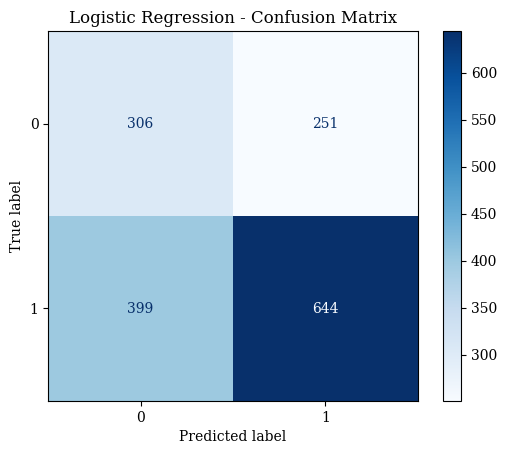

In [299]:
# Set up the model and hyperparameter grid
lr_model = LogisticRegression(max_iter=10000, random_state=42)
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced']
}

# Perform GridSearchCV for hyperparameter tuning
lr_grid = GridSearchCV(lr_model, lr_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
lr_grid.fit(X_train_resampled, y_train_resampled)

print("\n🔹 Logistic Regression")
lr_best = lr_grid.best_estimator_
print("Best Parameters:", lr_grid.best_params_)

# Evaluate on test set
y_pred_lr = lr_best.predict(X_test)
y_prob_lr = lr_best.predict_proba(X_test)[:, 1]  # Get probabilities for ROC

# Print classification results
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Plot confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay(cm_lr).plot(cmap='Blues')
plt.title('Logistic Regression - Confusion Matrix')
plt.show()

# Store accuracy
model_scores['Logistic Regression'] = accuracy_score(y_test, y_pred_lr)



# XGBoost

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:34:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔸 XGBoost
Best Parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.7}
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.41      0.41       557
           1       0.68      0.68      0.68      1043

    accuracy                           0.59      1600
   macro avg       0.55      0.55      0.55      1600
weighted avg       0.59      0.59      0.59      1600



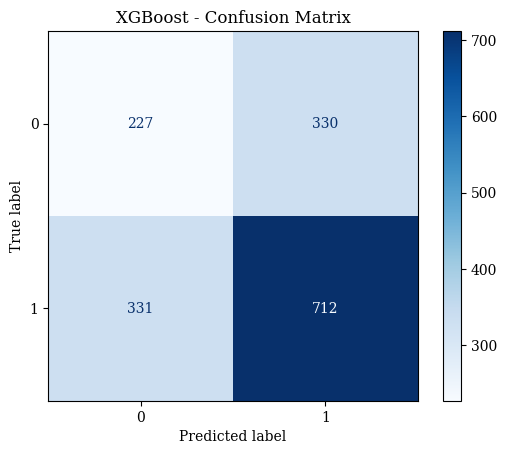

In [300]:
# Set up the model and hyperparameter grid
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 1.0],
}

# Perform GridSearchCV
xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train_resampled, y_train_resampled)

print("\n🔸 XGBoost")
xgb_best = xgb_grid.best_estimator_
print("Best Parameters:", xgb_grid.best_params_)

# Evaluate on test set
y_pred_xgb = xgb_best.predict(X_test)
y_prob_xgb = xgb_best.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
ConfusionMatrixDisplay(cm_xgb).plot(cmap='Blues')
plt.title('XGBoost - Confusion Matrix')
plt.show()

# Store accuracy
model_scores['XGBoost'] = accuracy_score(y_test, y_pred_xgb)


# LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4172, number of negative: 4172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6627
[LightGBM] [Info] Number of data points in the train set: 8344, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

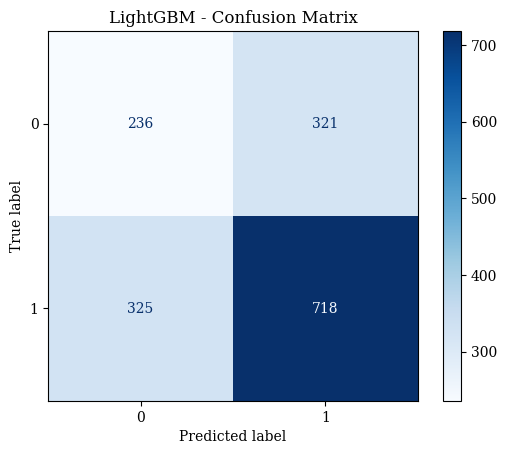

In [301]:
# Set up model and hyperparameter grid
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 50, 70],
}

# Perform GridSearchCV
lgb_grid = GridSearchCV(lgb_model, lgb_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
lgb_grid.fit(X_train_resampled, y_train_resampled)

print("\n🟢 LightGBM")
lgb_best = lgb_grid.best_estimator_
print("Best Parameters:", lgb_grid.best_params_)

# Evaluate on test set
y_pred_lgb = lgb_best.predict(X_test)
y_prob_lgb = lgb_best.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_lgb))

# Confusion matrix
cm_lgb = confusion_matrix(y_test, y_pred_lgb)
ConfusionMatrixDisplay(cm_lgb).plot(cmap='Blues')
plt.title('LightGBM - Confusion Matrix')
plt.show()

# Store accuracy
model_scores['LightGBM'] = accuracy_score(y_test, y_pred_lgb)



# Best model

In [302]:
#  Identify and print the best model based on accuracy
best_model_name = max(model_scores, key=model_scores.get)
best_model_accuracy = model_scores[best_model_name]

print(f"\n Best Model: {best_model_name} with Accuracy: {best_model_accuracy:.4f}")



 Best Model: LightGBM with Accuracy: 0.5962


# Implementing the best model on full dataset

تجربة

In [303]:
#  Prepare full dataset
full_x = DED_data.drop(columns=['Dry Eye Disease'])
full_y = DED_data['Dry Eye Disease']

#  Reconstruct full dataset using trained autoencoder
reconstructed_full_data = autoencoder.predict(full_x)

# Split into train/test
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    reconstructed_full_data, full_y, test_size=0.2, stratify=full_y, random_state=42
)

#  Apply SMOTE to training data
X_train_resampled_full, y_train_resampled_full = SMOTE(random_state=42).fit_resample(X_train_full, y_train_full)

# Use the best model identified earlier
best_model = None
if best_model_name == "Logistic Regression":
    best_model = LogisticRegression(**lr_grid.best_params_, max_iter=10000, random_state=42)
elif best_model_name == "XGBoost":
    best_model = xgb.XGBClassifier(**xgb_grid.best_params_, random_state=42)
elif best_model_name == "LightGBM":
    best_model = lgb.LGBMClassifier(**lgb_grid.best_params_, random_state=42)

# Train on full data
best_model.fit(X_train_resampled_full, y_train_resampled_full)



625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 10430, number of negative: 10430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6627
[LightGBM] [Info] Number of data points in the train set: 20860, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

LGBMClassifier(max_depth=7, n_estimators=200, num_leaves=70, random_state=42)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Final Evaluation on Full Dataset using LightGBM:
Accuracy: 0.5845
Precision: 0.686685104701699
Recall: 0.6666666666666666
F1 Score: 0.6765278318411834
---------------------------------------------



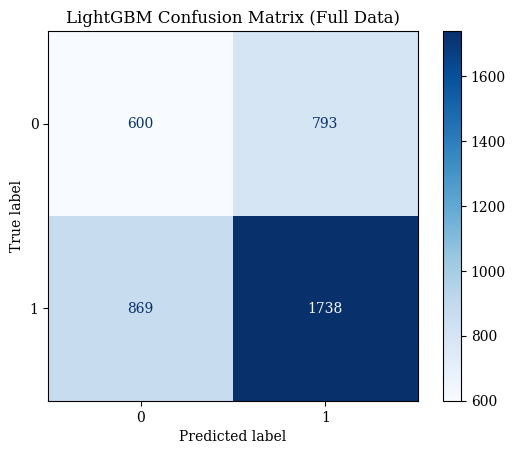

In [304]:
# Evaluate on test set
y_pred_final = best_model.predict(X_test_full)
y_prob_final = best_model.predict_proba(X_test_full)[:, 1]

#  Report results
print(f"\nFinal Evaluation on Full Dataset using {best_model_name}:")
print("Accuracy:", accuracy_score(y_test_full, y_pred_final))
print("Precision:", precision_score(y_test_full, y_pred_final))
print("Recall:", recall_score(y_test_full, y_pred_final))
print("F1 Score:", f1_score(y_test_full, y_pred_final))
print("---------------------------------------------\n")
# Confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test_full, y_pred_final), display_labels=best_model.classes_).plot(cmap='Blues')
plt.title(f"{best_model_name} Confusion Matrix (Full Data)")
plt.show()

